In [1]:
import numpy as np
import hist
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import os
import warnings

In [2]:
# Global variables
# ----------------

x0, x1 = 1, 100  # Integration interval
fit_on = True
nruns = 108  #  all: 108

In [3]:
# Fit functions definitions
# -------------------------

def nparam(func):
    n = 0
    if func is CB2:
        n = 7
    elif func is NA60:
        n = 11
    elif func is expVWG:
        n = 4
    elif func is expinterp:
        n = 4
    return n

def VWG(x, N, mu, alpha, beta):
    X = (x-mu)/mu
    sig = alpha + beta*X
    return N*np.exp(-(x-mu)**2/(2*sig**2))

def PL(x, N, mu, a1, a2, a3):
    return N*(1+a1*x)/(a2*x+a3*x)
    #return N*(a1*x**2+a2*x+a3)  # test
    
def DE(x, N, a1, a2, a3):
    return N*(np.exp(a1*x) + a2*np.exp(a3*x))

def expVWG(x, N, mu, alpha, beta):
    X = (x-mu)/mu
    sig = alpha + beta*X
    return np.exp(N*np.exp(-(x-mu)**2/(2*sig**2)))

def expinterp(x, y1, y2, y3, y4):
    xi = np.linspace(1, 5, 4)
    return np.exp(interp1d(xi, [y1, y2, y3, y4], kind='cubic', bounds_error=False, fill_value='extrapolate')(x))

def CB2(x, N, mu, sig, alphaL, nL, alphaR, nR):
    if (type(x) is float):
        x = np.array([x])
    AL = ( nL / np.absolute( alphaL ) )**nL * np.exp( -1 * np.absolute( alphaL )**2 / 2 )
    AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
    BL = nL / np.absolute( alphaL ) - np.absolute( alphaL )
    BR = nR / np.absolute( alphaR ) - np.absolute( alphaR )

    result = np.zeros(np.shape(x))
    
    rel = ( x - mu )/sig
    I1 = rel < -1 * alphaL
    I2 = (rel >= -1 * alphaL) * (rel <= alphaR)
    I3 = rel > alphaR
    result[I1] = AL * (BL - rel[I1])**(-nL)
    result[I2] = np.exp(-1 * rel[I2]**2 / 2)
    result[I3] = AR*(BR + rel[I3])**(-nR)
        
    return result * N #/ (np.sqrt(2 * np.pi) * sig)

def NA60(x, N, mu, sig, alphaL, alphaR, p1L, p1R, p2L, p2R, p3L, p3R):
    t = (x-mu)/sig
    I1 = t < alphaL
    I2 = (alphaL <= t)*(t <= alphaR)
    I3 = t > alphaR
    t0 = np.zeros(np.shape(x))
    t0[I1] = (1+p1L*(alphaL-t)**(p2L-p3L*np.sqrt(alphaL-t)))[I1]
    t0[I2] = 1
    t0[I3] = (1+p1R*(t-alphaR)**(p2R-p3R*np.sqrt(t-alphaR)))[I3]
    return N*np.exp(-0.5*(t**2/t0**2))


def sig2CB2(cov,  x, *args):
    # CB2 Derivatives
    def intervals(rel, alphaL, alphaR):
        I1 = rel < -1 * alphaL
        I2 = (rel >= -1 * alphaL) * (rel <= alphaR)
        I3 = rel > alphaR
        return I1, I2, I3

    def dCB2dN(x, N, mu, sig, alphaL, nL, alphaR, nR):
        if (type(x) is float):
            x = np.array([x])
        rel = (x-mu)/sig
        I1, I2, I3 = intervals(rel, alphaL, alphaR)
        res = np.zeros(np.shape(x))
        res[I1] = ((nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)[I1]
        res[I2] = (np.exp(-(-mu + x)**2/(2*sig**2)))                                                                             [I2]
        res[I3] = ((nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR)[I3]
        return res

    def dCB2dmu(x, N, mu, sig, alphaL, nL, alphaR, nR):
        if (type(x) is float):
            x = np.array([x])
        rel = (x-mu)/sig
        I1, I2, I3 = intervals(rel, alphaL, alphaR)
        res = np.zeros(np.shape(x))
        res[I1] = (-N*nL*(nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(sig*(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)*(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)) [I1]
        res[I2] = (-N*(2*mu - 2*x)*np.exp(-(-mu + x)**2/(2*sig**2))/(2*sig**2)                                                                                                                   ) [I2]
        res[I3] = (N*nR*(nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(sig*(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)*(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR) ) [I3]
        return res

    def dCB2dsig(x, N, mu, sig, alphaL, nL, alphaR, nR):
        if (type(x) is float):
            x = np.array([x])
        rel = (x-mu)/sig
        I1, I2, I3 = intervals(rel, alphaL, alphaR)
        res = np.zeros(np.shape(x))
        res[I1] = (-N*nL*(nL/np.abs(alphaL))**nL*(-mu + x)*np.exp(-np.abs(alphaL)**2/2)/(sig**2*(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)*(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)) [I1]
        res[I2] = (N*(-mu + x)**2*np.exp(-(-mu + x)**2/(2*sig**2))/sig**3                                                                                                                                     ) [I2]
        res[I3] = (N*nR*(nR/np.abs(alphaR))**nR*(-mu + x)*np.exp(-np.abs(alphaR)**2/2)/(sig**2*(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)*(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR) ) [I3]
        return res
    
    def IdCB2dN(x, *args):
        return quad(dCB2dN, x0, x1, args=args)[0]

    def IdCB2dmu(x, *args):
        return quad(dCB2dmu, x0, x1, args=args)[0]

    def IdCB2dsig(x, *args):
        return quad(dCB2dsig, x0, x1, args=args)[0]
    
    return IdCB2dN(x, *args)**2 * cov[0,0] \
    +IdCB2dmu(x, *args)**2 * cov[1,1] \
    +IdCB2dsig(x, *args)**2 * cov[2,2] \
    +2*IdCB2dN(x, *args)*IdCB2dmu(x, *args) * np.sqrt(np.abs(cov[0, 1])) \
    +2*IdCB2dN(x, *args)*IdCB2dsig(x, *args) * np.sqrt(np.abs(cov[0, 2])) \
    +2*IdCB2dmu(x, *args)*IdCB2dsig(x, *args) * np.sqrt(np.abs(cov[1, 2]))
    
def sig2NA60(cov, x, *args):
    def intervals(t, alphaL, alphaR):
        I1 = t < alphaL
        I2 = (alphaL <= t)*(t <= alphaR)
        I3 = t > alphaR
        return I1, I2, I3


    def dNA60dN(x, N, mu, sig, alphaL, alphaR, p1L, p1R, p2L, p2R, p3L, p3R):
        if (type(x) is float):
            x = np.array([x])
        t = (x-mu)/sig
        I1, I2, I3 = intervals(t, alphaL, alphaR)
        t0 = np.zeros(np.shape(x))
        t0[I1] = (np.exp(-0.5*(-mu + x)**2/(sig**2*(p1L*(alphaL - (-mu + x)/sig)**(p2L - p3L*np.sqrt(alphaL - (-mu + x)/sig)) + 1)**2))  )[I1]
        t0[I2] = (np.exp(-0.5*(-mu + x)**2/sig**2)                                                                                       )[I2]
        t0[I3] = (np.exp(-0.5*(-mu + x)**2/(sig**2*(p1R*(-alphaR + (-mu + x)/sig)**(p2R - p3R*np.sqrt(-alphaR + (-mu + x)/sig)) + 1)**2)))[I3]
        return N*np.exp(-0.5*(t**2/t0**2))

    def dNA60dmu(x, N, mu, sig, alphaL, alphaR, p1L, p1R, p2L, p2R, p3L, p3R):
        if (type(x) is float):
            x = np.array([x])
        t = (x-mu)/sig
        I1, I2, I3 = intervals(t, alphaL, alphaR)
        t0 = np.zeros(np.shape(x))
        t0[I1] = (N*(1.0*p1L*(alphaL - (-mu + x)/sig)**(p2L - p3L*np.sqrt(alphaL - (-mu + x)/sig))*(-mu + x)**2*(-p3L*np.log(alphaL - (-mu + x)/sig)/(2*sig*np.sqrt(alphaL - (-mu + x)/sig)) + (p2L - p3L*np.sqrt(alphaL - (-mu + x)/sig))/(sig*(alphaL - (-mu + x)/sig)))/(sig**2*(p1L*(alphaL - (-mu + x)/sig)**(p2L - p3L*np.sqrt(alphaL - (-mu + x)/sig)) + 1)**3) - 0.5*(2*mu - 2*x)/(sig**2*(p1L*(alphaL - (-mu + x)/sig)**(p2L - p3L*np.sqrt(alphaL - (-mu + x)/sig)) + 1)**2))*np.exp(-0.5*(-mu + x)**2/(sig**2*(p1L*(alphaL - (-mu + x)/sig)**(p2L - p3L*np.sqrt(alphaL - (-mu + x)/sig)) + 1)**2))            )[I1]
        t0[I2] = (-0.5*N*(2*mu - 2*x)*np.exp(-0.5*(-mu + x)**2/sig**2)/sig**2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           )[I2]
        t0[I3] = (N*(1.0*p1R*(-alphaR + (-mu + x)/sig)**(p2R - p3R*np.sqrt(-alphaR + (-mu + x)/sig))*(-mu + x)**2*(p3R*np.log(-alphaR + (-mu + x)/sig)/(2*sig*np.sqrt(-alphaR + (-mu + x)/sig)) - (p2R - p3R*np.sqrt(-alphaR + (-mu + x)/sig))/(sig*(-alphaR + (-mu + x)/sig)))/(sig**2*(p1R*(-alphaR + (-mu + x)/sig)**(p2R - p3R*np.sqrt(-alphaR + (-mu + x)/sig)) + 1)**3) - 0.5*(2*mu - 2*x)/(sig**2*(p1R*(-alphaR + (-mu + x)/sig)**(p2R - p3R*np.sqrt(-alphaR + (-mu + x)/sig)) + 1)**2))*np.exp(-0.5*(-mu + x)**2/(sig**2*(p1R*(-alphaR + (-mu + x)/sig)**(p2R - p3R*np.sqrt(-alphaR + (-mu + x)/sig)) + 1)**2)) )[I3]
        return N*np.exp(-0.5*(t**2/t0**2))

    def dNA60dsig(x, N, mu, sig, alphaL, alphaR, p1L, p1R, p2L, p2R, p3L, p3R):
        if (type(x) is float):
            x = np.array([x])
        t = (x-mu)/sig
        I1, I2, I3 = intervals(t, alphaL, alphaR)
        t0 = np.zeros(np.shape(x))
        t0[I1] = (N*(1.0*p1L*(alphaL - (-mu + x)/sig)**(p2L - p3L*np.sqrt(alphaL - (-mu + x)/sig))*(-mu + x)**2*(-p3L*(-mu + x)*np.log(alphaL - (-mu + x)/sig)/(2*sig**2*np.sqrt(alphaL - (-mu + x)/sig)) + (-mu + x)*(p2L - p3L*np.sqrt(alphaL - (-mu + x)/sig))/(sig**2*(alphaL - (-mu + x)/sig)))/(sig**2*(p1L*(alphaL - (-mu + x)/sig)**(p2L - p3L*np.sqrt(alphaL - (-mu + x)/sig)) + 1)**3) + 1.0*(-mu + x)**2/(sig**3*(p1L*(alphaL - (-mu + x)/sig)**(p2L - p3L*np.sqrt(alphaL - (-mu + x)/sig)) + 1)**2))*np.exp(-0.5*(-mu + x)**2/(sig**2*(p1L*(alphaL - (-mu + x)/sig)**(p2L - p3L*np.sqrt(alphaL - (-mu + x)/sig)) + 1)**2))            )[I1]
        t0[I2] = (1.0*N*(-mu + x)**2*np.exp(-0.5*(-mu + x)**2/sig**2)/sig**3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      )[I2]
        t0[I3] = (N*(1.0*p1R*(-alphaR + (-mu + x)/sig)**(p2R - p3R*np.sqrt(-alphaR + (-mu + x)/sig))*(-mu + x)**2*(p3R*(-mu + x)*np.log(-alphaR + (-mu + x)/sig)/(2*sig**2*np.sqrt(-alphaR + (-mu + x)/sig)) - (-mu + x)*(p2R - p3R*np.sqrt(-alphaR + (-mu + x)/sig))/(sig**2*(-alphaR + (-mu + x)/sig)))/(sig**2*(p1R*(-alphaR + (-mu + x)/sig)**(p2R - p3R*np.sqrt(-alphaR + (-mu + x)/sig)) + 1)**3) + 1.0*(-mu + x)**2/(sig**3*(p1R*(-alphaR + (-mu + x)/sig)**(p2R - p3R*np.sqrt(-alphaR + (-mu + x)/sig)) + 1)**2))*np.exp(-0.5*(-mu + x)**2/(sig**2*(p1R*(-alphaR + (-mu + x)/sig)**(p2R - p3R*np.sqrt(-alphaR + (-mu + x)/sig)) + 1)**2)) )[I3]
        return N*np.exp(-0.5*(t**2/t0**2))


    def IdNA60dN(x, *args):
        return quad(dNA60dN, x0, x1, args=args)[0]

    def IdNA60dmu(x, *args):
        return quad(dNA60dmu, x0, x1, args=args)[0]

    def IdNA60dsig(x, *args):
        return quad(dNA60dsig, x0, x1, args=args)[0]

    #plt.figure(); plt.plot(x, dNA60dmu(x, *args))  
   
    return IdNA60dN(x, *args)**2 * cov[0,0] \
    + IdNA60dmu(x, *args)**2 * cov[1,1] \
    + IdNA60dsig(x, *args)**2 * cov[2,2] \
    #+2*IdNA60dN(x, *args)*IdNA60dmu(x, *args) * np.sqrt(np.abs(cov[0, 1])) \
    #+2*IdNA60dN(x, *args)*IdNA60dsig(x, *args) * np.sqrt(np.abs(cov[0, 2])) \
    #+2*IdNA60dmu(x, *args)*IdNA60dsig(x, *args) * np.sqrt(np.abs(cov[1, 2]))
    
    
    
def datamodel(resofunc, bgfunc):
    nparamreso = nparam(resofunc)
    def f(x, *args):
        return resofunc(x, *args[:nparamreso]) + resofunc(x, *args[nparamreso:2*nparamreso]) + bgfunc(x, *args[2*nparamreso:])
    return f
    
def sig2(func):
    if func is CB2:
        f = sig2CB2
    elif func is NA60:  # NA60 intgral derivative seems to high compared to CB2
        f = sig2NA60
    return f


In [4]:
def gethistdata(h,xmin,xmax):
    ''' Get data from histo '''
    y,x = h[xmin*1j:xmax*1j].to_numpy()
    x = x[:-1]+(x[1]-x[0])/2  # set x to middles instead of lower bound of bins
    return x,y

def fillhist(h,type,pTl,pTu):
    f = open(f'mass/{type}.pT{pTl}-{pTu}.npy', 'rb')
    for i in range(nruns):
        A = np.load(f)
        #print(A)
        h.fill(A)
    f.close()

# p0
def p0reso(resofunc, hJPsi, hPsi2S):
    if resofunc is CB2:
        p0tails = [9.96e-01, 3.04e+00, 1.82e+00, 2.55e+01]
        p0JPsi = np.array([(hJPsi[3.10*1j]), 3.10, 7.29e-02, *p0tails])
        p0Psi2S = np.array([(hPsi2S[3.68*1j]), 3.68, 7.29e-02, *p0tails])
    elif resofunc is NA60:
        p0tails = [1, 1.8, 1, 1, 1, 1, 1, 1]
        p0JPsi = np.array([(hJPsi[3.10*1j]), 3.10, 7.29e-02, *p0tails])
        p0Psi2S = np.array([(hPsi2S[3.68*1j]), 3.68, 7.29e-02, *p0tails])
    return p0JPsi, p0Psi2S
    
# Make bounds
def mklb(p0, var):
    return p0*(1-np.sign(p0)*var)

def mkub(p0, var):
    return p0*(1+np.sign(p0)*var)

In [5]:
warnings.filterwarnings('ignore')
    
def setaxes(ax, show_xlabel, show_ylabel):
    ax.set_ylim(2e1,3e5)
    ax.set_yscale("log")
    ax.set_xlabel('')
    ax.set_ylabel('')
    if show_xlabel: ax.set_xlabel('$m\mu\mu$ (GeV/c$^2$)')
    if show_ylabel: ax.set_ylabel("Tracks counts")


def textpTrange(ax, pTl, pTu):
    ax.text(2, 1.5e5, f"{pTl} < $p_T$ < {pTu} GeV/c")
    

def fitroutine(pTl, pTu, axes=None, nbin=90, massmin=1.5, massmax=5.0,
               resofunc=CB2, bgfunc=expinterp,
               plot_on=False, show_range=False,
               show_xlabel=False, show_ylabel=False):
    
    dmass = (massmax-massmin)/nbin
    
    # Fill histograms
    hJPsi = hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))
    hPsi2S = hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))
    hdata = hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))
    fillhist(hJPsi,'JPsi',pTl,pTu)
    fillhist(hPsi2S,'Psi2S',pTl,pTu)
    fillhist(hdata,'data',pTl,pTu)
    
    mass,NJPsi = gethistdata(hJPsi,massmin,massmax)
    mass,NPsi2S = gethistdata(hPsi2S,massmin,massmax)
    mass,Ndata = gethistdata(hdata,massmin,massmax)
    
    
    ##########################
    #  MC Crystal Balls fit  #
    ##########################
    
    if 1:
        if plot_on: 
            ax = axes[0]
            hJPsi.plot(ax=ax, label="", color='black', ls='-', lw=0.5);
            hPsi2S.plot(ax=ax, label="", color='black', ls='-', lw=0.5);
            setaxes(ax, show_xlabel, show_ylabel)
            if show_range: textpTrange(ax, pTl, pTu)
        
        # Intervals for fit
        DJPsi = NJPsi>0
        DPsi2S = NPsi2S>0

        # p0
        p0JPsi, p0Psi2S = p0reso(resofunc, hJPsi, hPsi2S)
        
        if plot_on:
            pass
            #ax.plot(mass[DJPsi], (resofunc(mass, *p0JPsi))[DJPsi],'-r', alpha=0.5, label="")
            #ax.plot(mass[DPsi2S], (resofunc(mass, *p0Psi2S))[DPsi2S],'-r', alpha=0.5, label="")
 
        # Fit JPsi and Psi2S independently
        if fit_on:
            try:
                pfitJPsi, _ = curve_fit(resofunc, mass[DJPsi], NJPsi[DJPsi], sigma=np.sqrt(NJPsi[DJPsi]), p0=p0JPsi, method='trf')
                pfitPsi2S, _ = curve_fit(resofunc, mass[DPsi2S], NPsi2S[DPsi2S], sigma=np.sqrt(NPsi2S[DPsi2S]), p0=p0Psi2S, method='trf')
                if plot_on: 
                    ax.plot(mass[DJPsi], resofunc(mass,*pfitJPsi)[DJPsi], 'b')
                    ax.plot(mass[DPsi2S], resofunc(mass,*pfitPsi2S)[DPsi2S], 'b')
            except Exception as e:
                #raise(e)
                pass
   
    #########################
    #  Data background fit  #
    #########################
    
    if 1:
        # Remove JPsi and Psi2S intervals from data in order to fit the background only
        if i==1:
            Dbg = ~((2.7<mass)*(mass<3.9))
        else:    
            Dbg = ~((2.1<mass)*(mass<4.0))
        
        if plot_on:
            ax = axes[1]
            hdata.plot(ax=ax, color='black',ls='-',lw=0.5)
            ax.plot(mass[Dbg],Ndata[Dbg],'+g')
            setaxes(ax, show_xlabel, show_ylabel)
            if show_range: textpTrange(ax, pTl, pTu)

        #p0 = [1e3, -1, 1e2, -3]
        #bounds = ([0, -10, 0, -10],[1e5, 0, 1e4, 0])
        #ax.plot(mass,(DE(mass,*p0)))
        
        # Fit bg
        if fit_on:
            try:
                pfitbg, covbg = curve_fit(bgfunc, mass[Dbg], (Ndata[Dbg]), sigma=np.sqrt(Ndata[Dbg]), method='trf')
                if plot_on: ax.plot(mass,(bgfunc(mass,*pfitbg)),'b')
            except Exception as e:
                #raise(e)
                pass

    ###############
    #  Final fit  #
    ###############
    
    if 1:
        if plot_on: 
            ax = axes[2]
            hdata.plot(ax=ax,label="Selected events",color='black',ls='-',lw=0.5)
            setaxes(ax, show_xlabel, show_ylabel)
            if show_range: textpTrange(ax, pTl, pTu)
        
        if fit_on:
            # bounds
            rbg = np.ones(np.shape(pfitbg))*0.05 # bg parameters variation factor around p0
            rreso = np.array([10, 0.02, 0.02, *0.001*np.ones(nparam(resofunc)-3)])  # peaks parameters variation factor around p0
            lb = np.array([*mklb(pfitJPsi, rreso), *mklb(pfitPsi2S, rreso), *mklb(pfitbg, rbg)])
            ub = np.array([*mkub(pfitJPsi, rreso), *mkub(pfitPsi2S, rreso), *mkub(pfitbg, rbg)])
            bounds = (lb,ub)
            
            # Overwrite p0 peaks amplitudesfrom data
            pfitJPsi[0] = (hdata[pfitJPsi[1]*1j])
            pfitPsi2S[0] = (hdata[pfitPsi2S[0]*1j])
            
            try:
                pfit, cov = curve_fit(
                    datamodel(resofunc, bgfunc), mass, Ndata,
                    sigma=np.sqrt(Ndata),
                    p0=[*pfitJPsi, *pfitPsi2S, *pfitbg],
                    bounds=bounds,
                    method='trf')                
                #print(pfit)

                Nfit = datamodel(resofunc, bgfunc)(mass, *pfit)
                NJPsi = resofunc(mass, *pfit[:nparam(resofunc)])
                NPsi2S = resofunc(mass, *pfit[nparam(resofunc):2*nparam(resofunc)])
                if plot_on: 
                    ax.plot(mass, Nfit,'b')
                    ax.plot(mass, NJPsi,'--b',lw=0.5)
                    ax.plot(mass, NPsi2S,'--b',lw=0.5)
                    ax.plot(mass, bgfunc(mass, *pfit[2*nparam(resofunc):]),'--b',lw=0.5)
                
                #print(cov/abs(pfit))
                # Fit error
                cov[3:nparam(resofunc)] = 0
                cov[nparam(resofunc)+3:2*nparam(resofunc)] = 0
                errfit = np.sqrt(np.sum(np.diag(cov)))

                if plot_on: ax.fill_between(mass, Nfit-errfit, Nfit+errfit, color='blue', alpha=0.1) 
                
                # J/psi Integral
                IJPsi = quad(resofunc, x0, x1, args=tuple(pfit[:nparam(resofunc)]))[0]

                # J/psi Integral stat error
                errIJPsi = np.sqrt(sig2(resofunc)(cov[:3,:3], mass, *pfit[:nparam(resofunc)]))
                if plot_on: ax.text(2.4, 6e4, f'$N_{{J/\psi}}$ = {IJPsi/dmass:.0f} $\pm$ {errIJPsi/dmass:.0f} (stat)')
                #print(IJPsi/dmass)
                #print(errJPsi/dmass)
            except Exception as e:
                raise(e)
                pass
    return IJPsi/dmass, errIJPsi/dmass

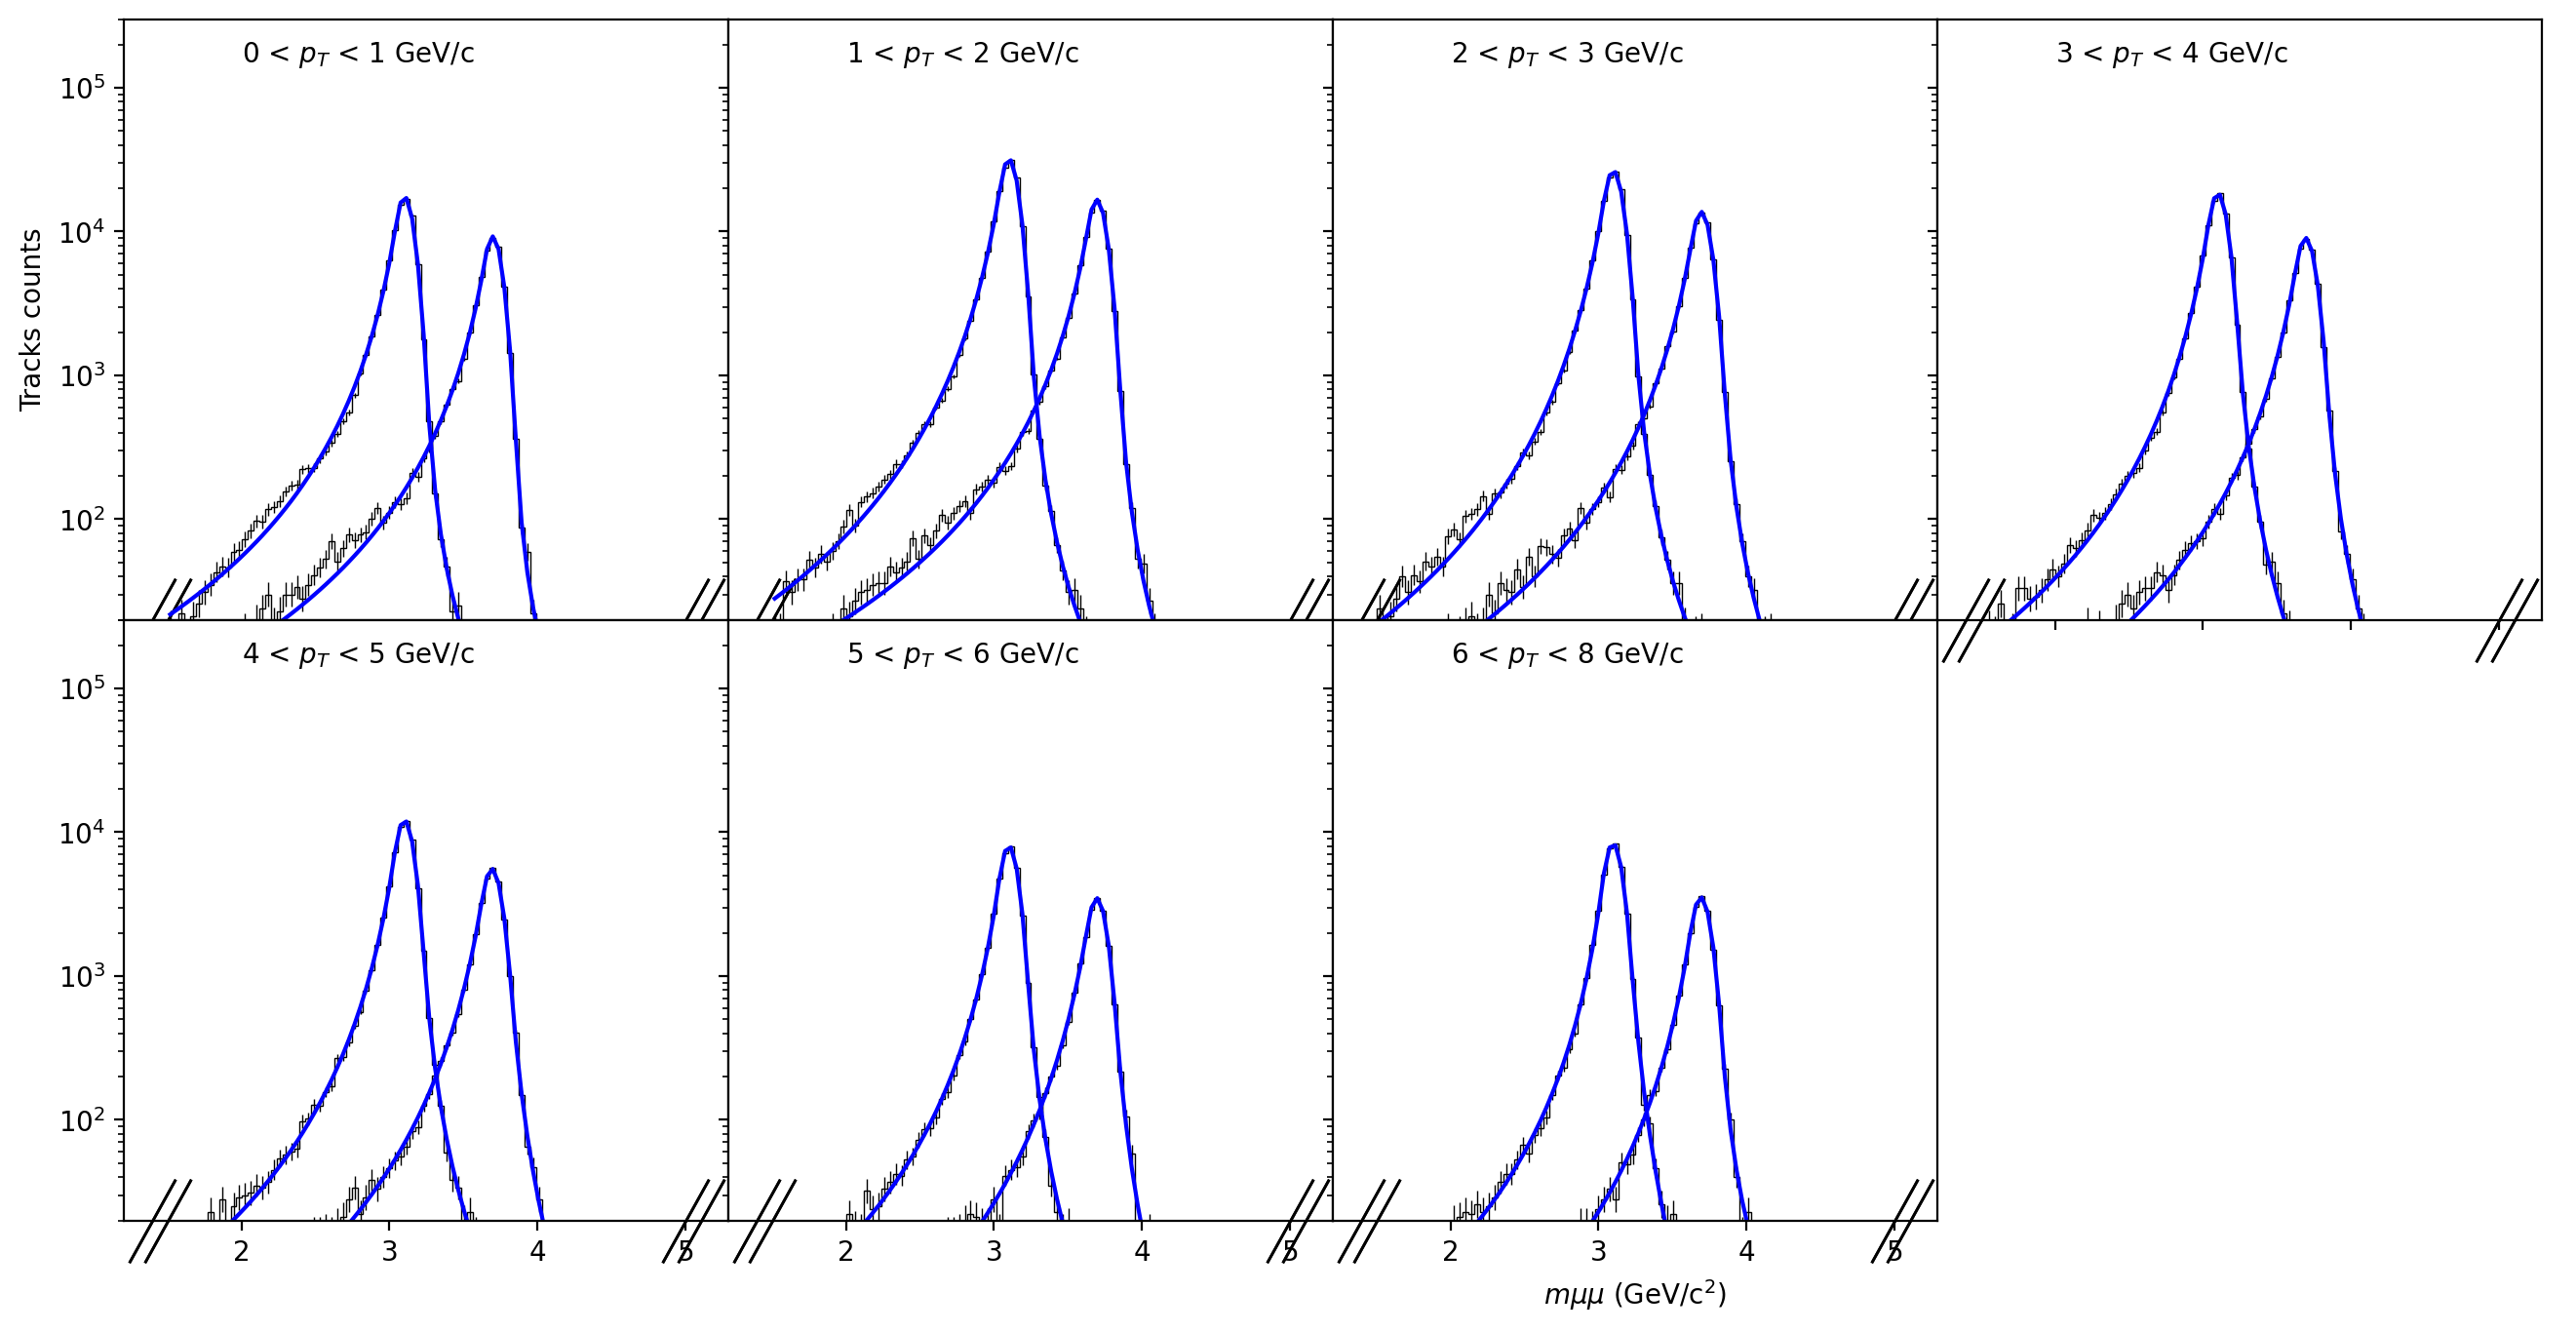

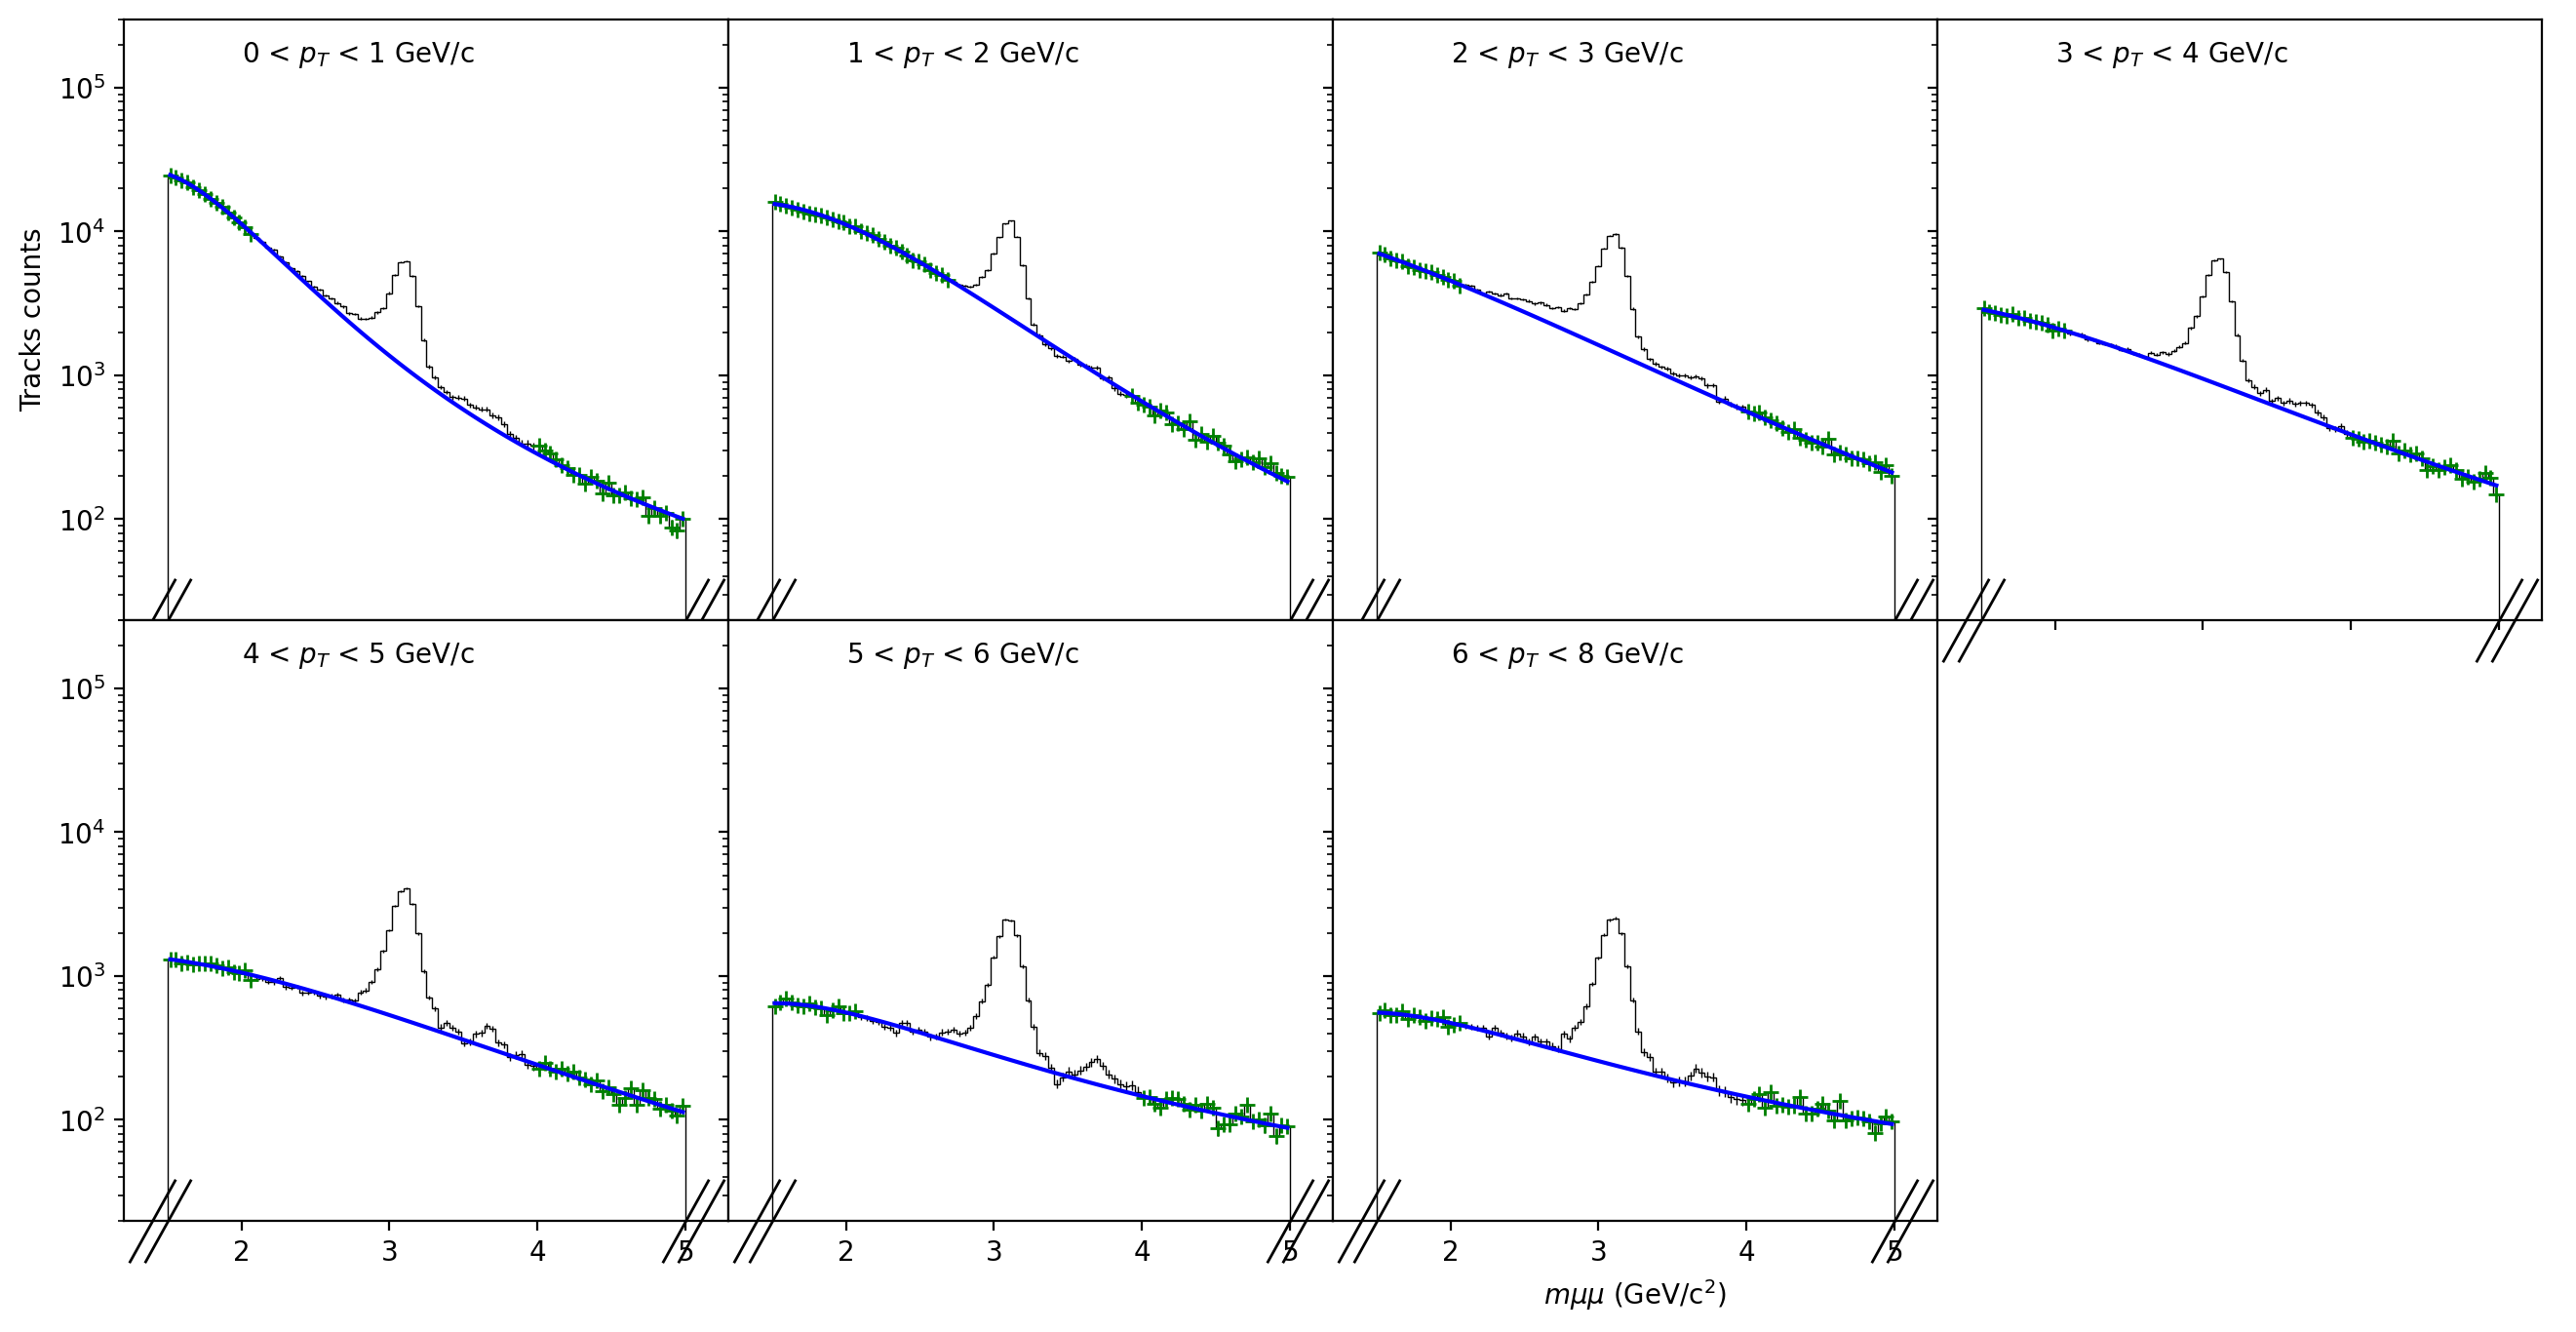

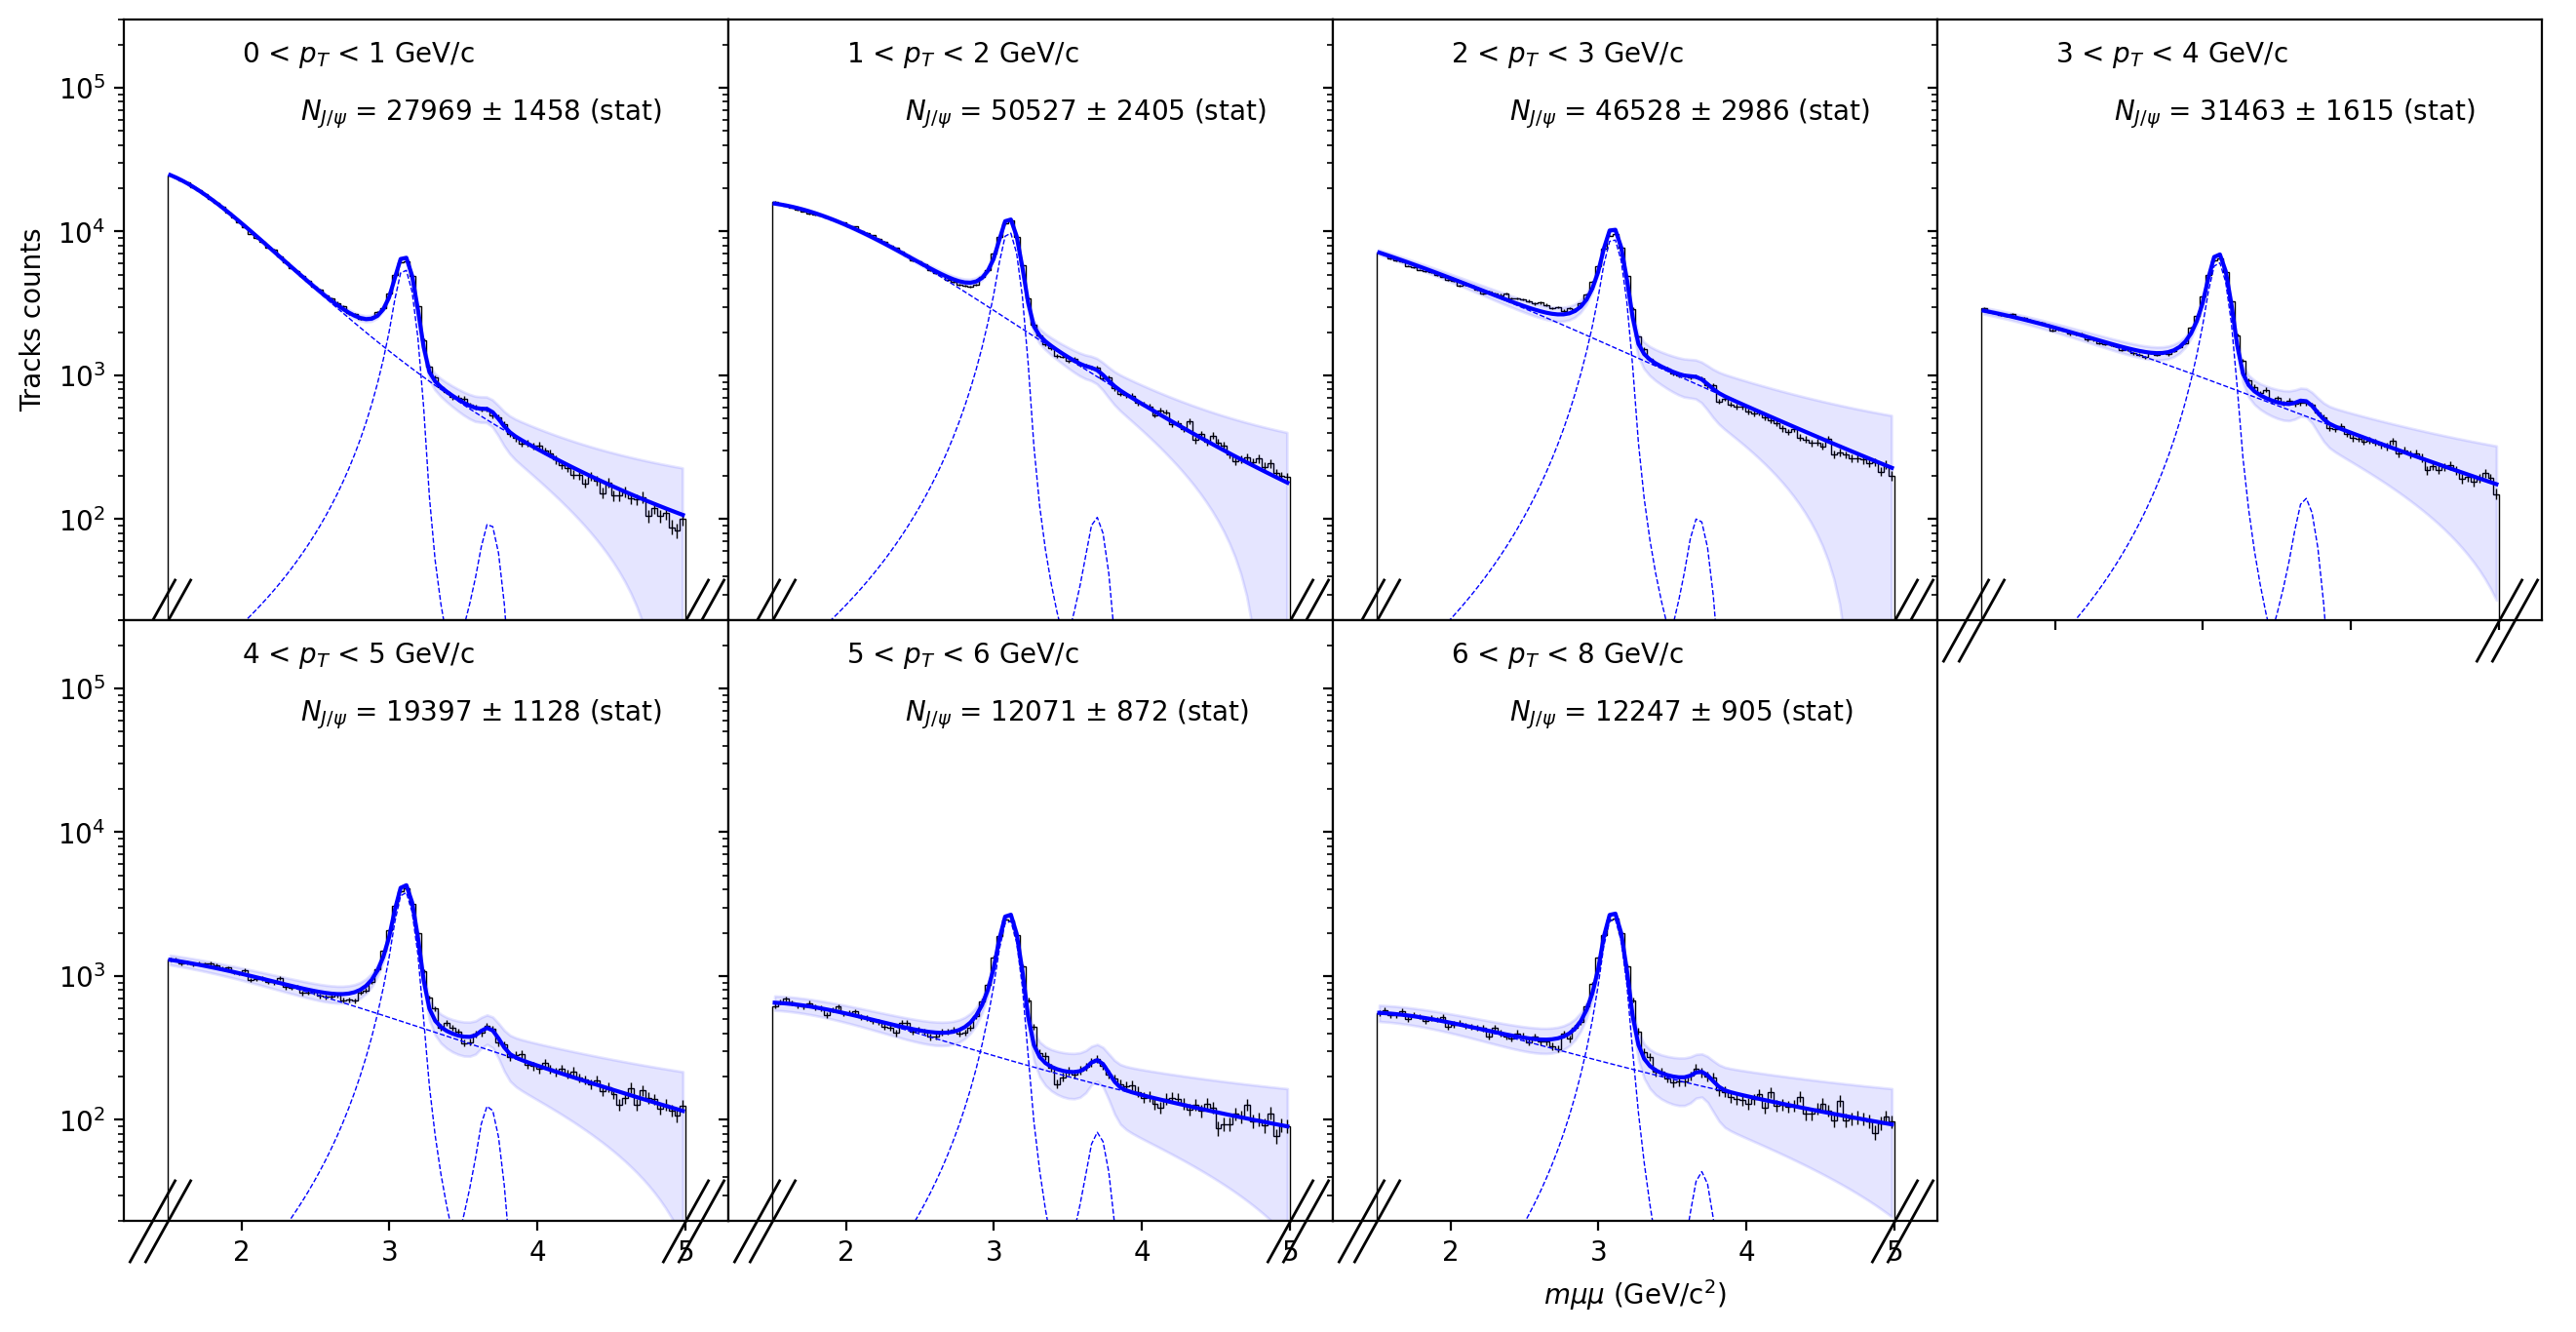

In [6]:
#  pT differential analysis
#  ------------------------

fig = []
axes = []
for i in range(3):
    fig.append(plt.figure(i+1, dpi=200, figsize=(16,8)))
    gs = fig[i].add_gridspec(2, 4, hspace=0, wspace=0)
    axes.append(gs.subplots(sharex='col', sharey='row'))
    axes[i][1,-1].remove()

IJPsi_pT = []

pTcuts = [0,1,2,3,4,5,6,8]
for i in range(len(pTcuts)-1):
    pTl = pTcuts[i]
    pTu = pTcuts[i+1]
    
    fitroutine(pTl, pTu,
               axes=[axes[j].flatten()[i] for j in range(3)],
               nbin=90, massmin=1.5, massmax=5.0,
               resofunc=CB2, bgfunc=expVWG,
               plot_on=True, show_range=True,
               show_xlabel=(i==6), show_ylabel=(i==0))
            
#fig[0].savefig('fig/diff_MC_fit.pdf')
#fig[1].savefig('fig/diff_bg_fit.pdf')
fig[2].savefig('fig/diff_fit.pdf')

In [252]:
#  All pT final plot
#  -----------------
def p0reso(func):
    if func is CB2:
        p0JPsi = [40248.03611688854, 3.1043969164973095, 0.05916830498610536, 0.9498690813388607, 3.026452516177861, 2.3298518901185084, 4.293297264238038]  # Charlig
        p0Psi2S = [3e3, 3.69660321e+00, 5.93585320e-02, 7.45529120e-01, 4.99564973e+00, 2.30142894e+00, 3.08316961e+00]
    elif func is NA60:
        pass
    return p0JPsi, p0Psi2S
    
def mainfit(nbin, massmin, massmax, bgfunc=expVWG, resofunc=CB2, plot_on=False):
    dmass = (massmax-massmin)/nbin
    
    # Fill histograms
    #hmc = hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))
    hdata = hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))


    #fillhist(hmc, 'mc')
    fillhist(hdata, 'data', 0, 1000)

    mass, Ndata = gethistdata(hdata,massmin,massmax)

    if plot_on:
        fig = plt.figure()
        ax = plt.gca()
        hdata.plot(label="Selected MC events",color='black',ls='-',lw=0.5)

    #########################
    #  Data background fit  #
    #########################

    if 1:
        # Remove resonance interval from data in order to fit the background only
        Dbg = ~((2.3<mass)*(mass<4.0))

        # Fit bg
        try:
            pfitbg, covbg = curve_fit(bgfunc, mass[Dbg], (Ndata[Dbg]),
                                      sigma=np.sqrt(Ndata[Dbg]),
                                      bounds=(np.zeros(4), np.inf*np.ones(4)),
                                      method='trf')
        except Exception as e:
            raise(e)
            pass
    
    ###############
    #  Final fit  #
    ###############
    if 1:
        p0JPsi, p0Psi2S = p0reso(resofunc)
        # Make bounds
        rbg = np.ones(np.shape(pfitbg))*0.1 # bg parameters variation factor around p0
        rreso = np.array([10, 0.1, 0.1, *0.01*np.ones(4)])  # peaks parameters variation factor around p0
        lb = np.array([*mklb(p0Jreso, rreso), *mklb(p0Psi2S, rreso), *mklb(pfitbg, rbg)])
        ub = np.array([*mkub(p0JPsi, rreso), *mkub(p0Psi2S, rreso), *mkub(pfitbg, rbg)])
        bounds = (lb,ub)

        # Set p0 peaks amplitudesfrom data
        #p0JPsi[0] = (hdata[p0JPsi[1]*1j])
        #p0Psi2S[0] = (hdata[p0Psi2S[0]*1j])

        try:
            pfit, cov = curve_fit(
                datamodel(resofunc, bgfunc), mass, (Ndata),
                sigma=np.sqrt(Ndata),
                p0=[*p0JPsi, *p0Psi2S, *pfitbg],
                bounds=bounds,
                method='trf')

            Nfit = datamodel(resofunc, bgfunc)(mass,*pfit)
            NJPsi = resofunc(mass,*pfit[:nparam(resofunc)])
            NPsi2S = resofunc(mass,*pfit[nparam(resofunc):2*nparam(resofunc)])
            Nbg = bgfunc(mass,*pfit[2*nparam(resofunc):])
            if plot_on:
                ax.plot(mass, Nfit,'b')
                ax.plot(mass, NJPsi,'--b',lw=0.5)
                ax.plot(mass, NPsi2S,'--b',lw=0.5)
                ax.plot(mass, Nbg,'--b',lw=0.5)

            #print(cov/abs(pfit))
            # Fit error
            if resofunc is CB2:
                cov[3:7] = 0
                cov[10:14] = 0
            errfit = np.sqrt(np.sum((np.diag(cov))))

            if plot_on: ax.fill_between(mass, Nfit-errfit, Nfit+errfit, color='blue', alpha=0.1) 

            # J/psi Integral
            IJPsi = quad(resofunc, x0, x1, args=tuple(pfit[:nparam(resofunc)]))[0]

            # J/psi Integral error
            errJPsi = np.sqrt(sig2(resofunc)(cov[:3,:3], mass, *pfit[:nparam(resofunc)]))
            if plot_on: ax.text(3.3, 5e4, f'$N_{{J/\psi}}$ = {IJPsi/dmass:.0f} $\pm$ {errJPsi/dmass:.0f} (stat)')
            #print(IJPsi/dmass)
            #print(errJPsi/dmass)

        except Exception as e:
            raise(e)
            pass
    
    if plot_on:
        ax.set_ylim(1e2,1e5)
        ax.set_yscale("log")
        #ax.text(2, 5e4, f"")
        ax.set_xlabel('$m\mu\mu$ (GeV/c$^2$)')
        ax.set_ylabel("Tracks counts")

        fig.savefig('fig/all_pT_final_fit.pdf')

        #fig2 = plt.figure(3)
        #hdata.plot(label="Selected data events",color='black',ls='-',lw=0.5)
    
    return IJPsi/dmass, errJPsi/dmass


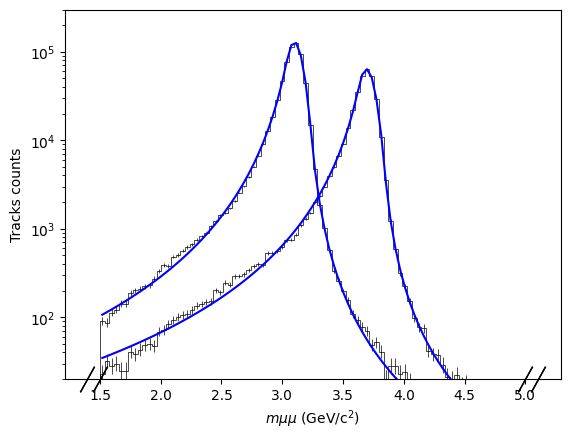

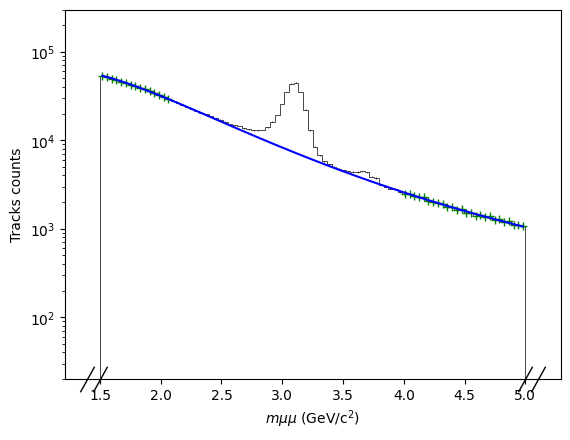

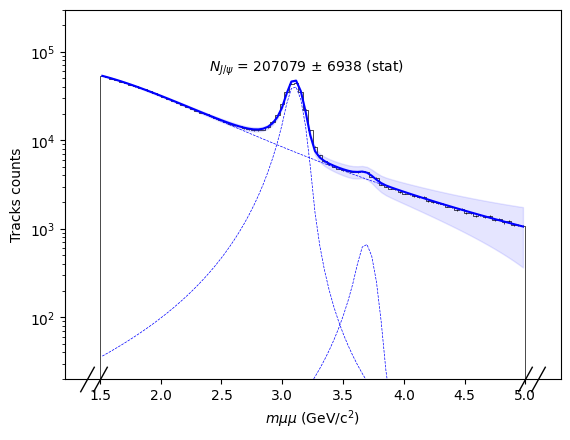

In [7]:
fig = []
axes = []
for i in range(3):
    fig.append(plt.figure())
    axes.append(plt.gca())
fitroutine(0, 1000,
           axes=axes,
           nbin=90, massmin=1.5, massmax=5.0,
           resofunc=CB2, bgfunc=expVWG,
           plot_on=True, show_range=False,
           show_xlabel=True, show_ylabel=True)
fig[2].savefig('fig/main_fit.pdf')

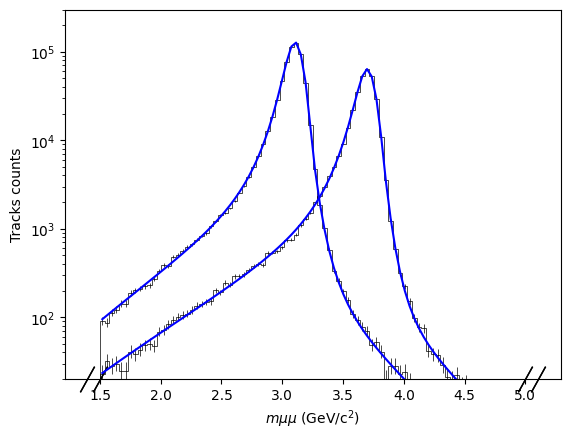

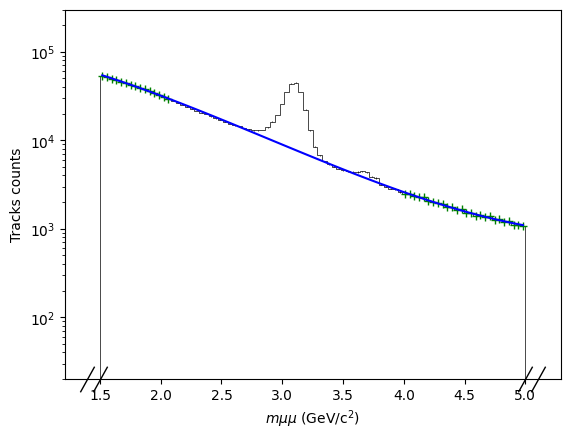

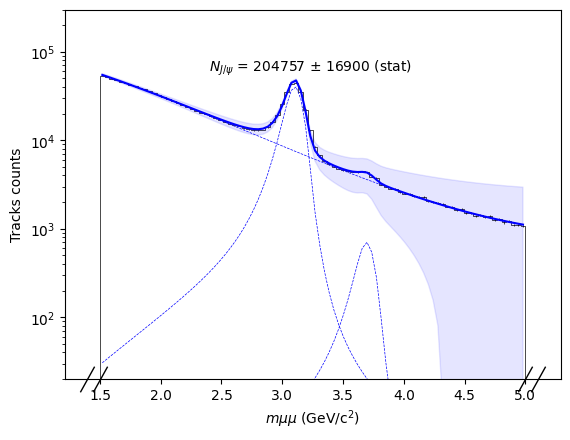

In [65]:
fig = []
axes = []
for i in range(3):
    fig.append(plt.figure())
    axes.append(plt.gca())
fitroutine(0, 1000,
           axes=axes,
           nbin=90, massmin=1.5, massmax=5.0,
           resofunc=NA60, bgfunc=expinterp,
           plot_on=True, show_range=False,
           show_xlabel=True, show_ylabel=True)

In [71]:
def syst(x):
    n = len(x)
    xmean = np.mean(x)
    return np.sqrt(sum((x-xmean)**2/(n-1)))

Text(124.5, 200090.5174614844, '$\\sigma_{syst}$ = 239')

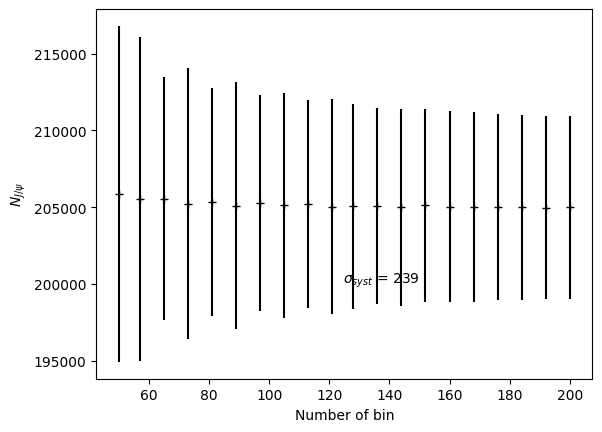

In [81]:
#  nbin systematic analysis
#  ------------------------

nbins = np.linspace(50,200,20, dtype=np.int16)
NJPsi_nbin = []
errNJPsi_nbin = []
for nbin in nbins:
    NJPsi, errNJPsi = fitroutine(0, 1000, axes=None, nbin=nbin, massmin=1.5, massmax=5.0,
                                 resofunc=CB2, bgfunc=expinterp,
                                 plot_on=False)
    NJPsi_nbin.append(NJPsi)
    errNJPsi_nbin.append(errNJPsi)
    
plt.errorbar(nbins, NJPsi_nbin, errNJPsi_nbin, fmt='+k')
plt.xlabel('Number of bin')
plt.ylabel('$N_{J/\psi}$')
plt.text(np.median(nbins), np.median(NJPsi_nbin)-5e3, f'$\sigma_{{syst}}$ = {syst(NJPsi_nbin):.0f}')

Text(1.5, 200566.92473359243, '$\\sigma_{syst}$ = 486')

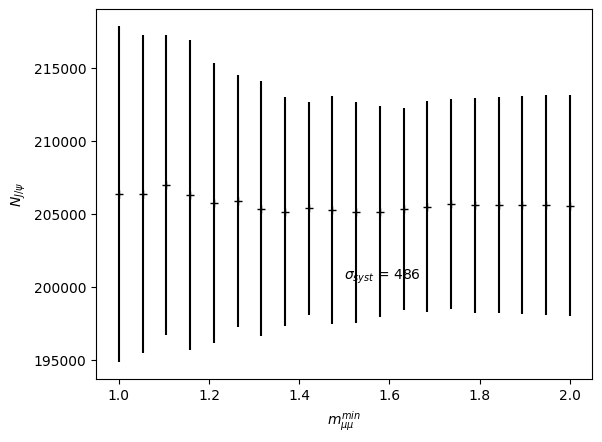

In [82]:
#  massmin systematic analysis
#  ---------------------------

massmins = np.linspace(1,2,20)
NJPsi_massmin = []
errNJPsi_massmin = []
for massmin in massmins:
    NJPsi, errNJPsi = fitroutine(0, 1000, axes=None, nbin=90, massmin=massmin, massmax=5.0,
                                 resofunc=CB2, bgfunc=expinterp,
                                 plot_on=False)
    NJPsi_massmin.append(NJPsi)
    errNJPsi_massmin.append(errNJPsi)
    
plt.errorbar(massmins, NJPsi_massmin, errNJPsi_massmin, fmt="+k")
plt.xlabel('$m_{\mu\mu}^{min}$')
plt.ylabel('$N_{J/\psi}$')
plt.text(np.median(massmins), np.median(NJPsi_massmin)-5e3, f'$\sigma_{{syst}}$ = {syst(NJPsi_massmin):.0f}')

In [90]:
#  Models systematic analysis
#  --------------------------
model_tests = []
models = (CB2, NA60, expVWG, expinterp)
combi = ((CB2, expVWG), (CB2, expinterp), (NA60, expVWG), (NA60, expinterp)) # all combinations of models
for resofunc, bgfunc in combi:
    model_tests.append(fitroutine(0, 1000, axes=None, nbin=90, massmin=1.5, massmax=5.0,
                                  resofunc=resofunc, bgfunc=bgfunc, plot_on=False)[0])

In [91]:
#  Systematic analysis
#  -------------------
NJPsi_tests = np.concatenate((NJPsi_nbin, NJPsi_massmin, model_tests))
errsyst = syst(NJPsi_tests)
print(errsyst)

548.7422073696496
